In [1]:
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


# Read and preprocess the data

In [2]:
# reading CSV file
reader = csv.reader(open('data/SL2.csv', 'r'), delimiter=',')

train = np.array(list(reader))
reader = csv.reader(open('data/PL.csv', 'r'), delimiter=',')
test = np.array(list(reader))

In [3]:
print train

[['' '' '' ..., '' '' '']
 ['Date' 'Day of the week' '1-workday, 2-Saturday, 3-Sunday, >4-untypical'
  ..., 'Hour 22' 'Hour 23' 'Hour 24']
 ['19990101' '5' '4.01' ..., '364431' '357204' '324412']
 ..., 
 ['20011229' '6' '2' ..., '431338' '412652' '376991']
 ['20011230' '7' '3' ..., '432592' '414905' '370274']
 ['20011231' '1' '4.13' ..., '408512' '403538' '383141']]


In [4]:
labels = test[1,:]
print labels

['Date' 'Day of the week' '1-workday, 2-Saturday, 3-Sunday, >4-untypical'
 'Hour 1' 'Hour 2' 'Hour 3' 'Hour 4' 'Hour 5' 'Hour 6' 'Hour 7' 'Hour 8'
 'Hour 9' 'Hour 10' 'Hour 11' 'Hour 12' 'Hour 13' 'Hour 14' 'Hour 15'
 'Hour 16' 'Hour 17' 'Hour 18' 'Hour 19' 'Hour 20' 'Hour 21' 'Hour 22'
 'Hour 23' 'Hour 24']


In [5]:
train = np.delete(train, [0,1], 0)
date_train = train[0, :]
weekday_train = train[1, :]
day_type_train = train[2, :]
train_set = np.delete(train, [0,1,2], 1)

In [6]:
test = np.delete(test, [0,1], 0)
date_test = test[0, :]
weekday_test = test[1, :]
day_type_test = test[2, :]
test_set = np.delete(test, [0,1,2], 1)

In [7]:
train_set = np.array(train_set, dtype='float32')
test_set = np.array(test_set, dtype='float32')

In [8]:
train_set = np.reshape(train_set, train_set.shape[0]*train_set.shape[1])
test_set = np.reshape(test_set, test_set.shape[0]*test_set.shape[1])

In [9]:
#test_set = (test_set - train_set.mean())/train_set.std()
#train_set = (train_set - train_set.mean())/train_set.std()

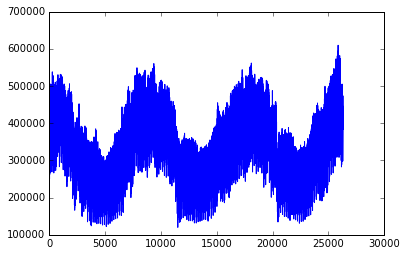

In [10]:
plt.plot(train_set)

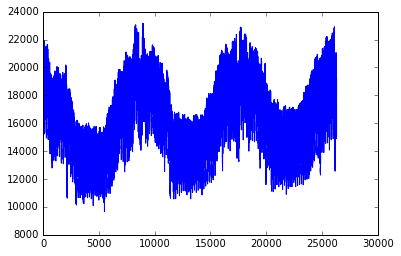

In [11]:
plt.plot(test_set)

In [12]:
def sample_random_batches(source,n_batches=10, seq_len=20):
    """
    This function takes random subsequences from the time series.

    Parameters:
        source - initial time series
        n_batches - how many subsequences are to be sampled
        seq_len - length of each of such subsequences
        
    
    Return:
     X - a matrix of float32 with shape [n_batches,seq_len]
        Each row of such matrix must be a subsequence of source 
            starting from random index (from 0 to N-seq_len-2)
     Y - a vector, where i-th number is one going RIGHT AFTER i-th row from X from source
     
    """
    
    X_batch = np.zeros(shape=(n_batches, seq_len))
    y_batch = np.zeros(shape=(n_batches, 1))
    for i in range(n_batches):
        k = np.random.randint(0, len(source)-seq_len-1)
        X_batch[i] = source[k:k+seq_len]
        y_batch[i] = source[k+seq_len]
    
    return X_batch, y_batch

# Constants

In [13]:
#Training sequence length
seq_length = 40

#max gradient between recurrent layer applications
grad_clip = 100

#values to be predicted
pred_len = 1

# Input values

In [14]:
input_sequence = T.matrix('input sequence')
target_values = T.matrix('target y')

# Neural network architecture

In [16]:

l_in = lasagne.layers.InputLayer(shape=(None, seq_length),input_var=input_sequence)

l1 = lasagne.layers.ExpressionLayer(l_in, lambda X: X.mean(axis=1), output_shape=(None, 1))
l1 = lasagne.layers.ReshapeLayer(l1, shape=(-1, 1))

l2 = lasagne.layers.ExpressionLayer(l_in, lambda X: X.std(axis=1), output_shape=(None, 1))
l2 = lasagne.layers.ReshapeLayer(l2, shape=(-1, 1))

l3 = lasagne.layers.ExpressionLayer(l_in, lambda X: 
                                    ((X.reshape([1, X.shape[0]*X.shape[1]]) - T.repeat(X.mean(axis=1), seq_length))/
                                     T.repeat(X.std(axis=1), seq_length)).reshape(X.shape),
                                    output_shape=(None, seq_length))

l4 = lasagne.layers.ReshapeLayer(l3, shape=(-1, seq_length, 1))

#l_rnn = lasagne.layers.RecurrentLayer(l4, num_units=32, grad_clipping=grad_clip, 
#                                      nonlinearity=lasagne.nonlinearities.tanh)
#l_rnn = lasagne.layers.RecurrentLayer(l_rnn, num_units=32, grad_clipping=grad_clip, 
#                                      nonlinearity=lasagne.nonlinearities.tanh)
l_rnn = lasagne.layers.LSTMLayer(l4, num_units=256, grad_clipping=grad_clip, 
                                    nonlinearity=lasagne.nonlinearities.tanh)
l_rnn = lasagne.layers.LSTMLayer(l_rnn, num_units=128, grad_clipping=grad_clip, 
                                    nonlinearity=lasagne.nonlinearities.tanh)
l_slice = lasagne.layers.SliceLayer(l_rnn, -1, 1)
l_dense = lasagne.layers.BatchNormLayer(l_slice)
l_dense = lasagne.layers.DenseLayer(l_dense, num_units=20, nonlinearity=lasagne.nonlinearities.tanh)
l_dense = lasagne.layers.BatchNormLayer(l_dense)
#l_dense = lasagne.layers.DenseLayer(l_dense, num_units=10, nonlinearity=lasagne.nonlinearities.tanh)
#l_dense = lasagne.layers.BatchNormLayer(l_dense)

l_out_norm = lasagne.layers.DenseLayer(l_dense, num_units=pred_len, nonlinearity=lasagne.nonlinearities.tanh)

l_out_mul = lasagne.layers.ElemwiseMergeLayer([l_out_norm, l2], merge_function = T.mul)
l_out = lasagne.layers.ElemwiseSumLayer([l_out_mul, l1])

In [17]:
a = theano.function([input_sequence], lasagne.layers.get_output(l_out))

In [18]:
print a([train_set[0:40], train_set[100:140]])

[[ 329095.23213729]
 [ 384010.17081078]]


In [19]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print weights

[W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, beta, gamma, W, b, beta, gamma, W, b]


In [20]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [21]:
network_output_norm = lasagne.layers.get_output(l_out_norm)

In [22]:
loss = T.mean(lasagne.objectives.squared_error(network_output, target_values))

#updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=2*10e-4, momentum=0.9)
updates = lasagne.updates.adagrad(loss, weights, learning_rate=8e-3)

# Compiling all functions

In [ ]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# next character probabilities
forecast = theano.function([input_sequence],network_output,allow_input_downcast=True)

# Training loop

In [ ]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 100

#how many training sequences are processed in a single function call
batch_size=100


for epoch in xrange(n_epochs):

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_random_batches(train_set,batch_size,seq_length)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))


# Testing perfomance

In [22]:

print("Testing ...")

n_test_runs = 100
avg_cost = 0;
    
for epoch in xrange(n_test_runs):

    x,y = sample_random_batches(test_set,1,seq_length)
    avg_cost = avg_cost + (y - forecast(x))**2
    
print("Average loss {} on {} test runs".format(avg_cost / n_test_runs, n_test_runs))


Testing ...


ValueError: Input dimension mis-match. (input[0].shape[1] = 1, input[2].shape[1] = 40)
Apply node that caused the error: Elemwise{Composite{((tanh((i0 + i1)) * i2) + i3)}}[(0, 0)](Dot22.0, InplaceDimShuffle{x,0}.0, Elemwise{Composite{sqrt((i0 / i1))}}[(0, 0)].0, mean)
Toposort index: 71
Inputs types: [TensorType(float64, matrix), TensorType(float64, row), TensorType(float64, row), TensorType(float64, row)]
Inputs shapes: [(1, 1), (1, 1), (1, 40), (1, 40)]
Inputs strides: [(8, 8), (8, 8), (320, 8), (320, 8)]
Inputs values: [array([[ nan]]), array([[ 0.]]), 'not shown', 'not shown']
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [32]:
print test_set

[ 15495.47460938  14972.75        14466.90039062 ...,  16022.875       15652.
  15141.90039062]
